In [1]:
### import all of the important modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as ss
import corner
import ultranest
import ellc
from astropy.io import fits

In [2]:
### define a name for the parameters
param_names = ["r1","r2","incl","t_zero","sbratio","A"]

time: [1468.27727442 1468.27866335 1468.28005229 ... 1490.04703722 1490.0484261
 1490.04981498]
flux: [464.35312 484.94705 494.5493  ... 525.1879  519.09064 532.0367 ]
flux_error: [7.4157424 7.444608  7.4689903 ... 7.8826923 7.8806467 7.8857975]
RA: 103.6293848603147
Dec: 8.92575385596458


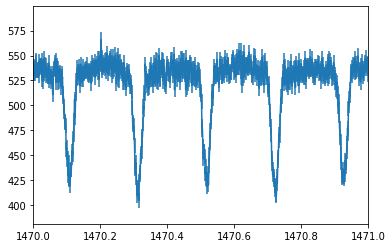

In [3]:
### define a function to read in the data (this is the same function that we have used in the previous modules)
def load_LC(f):
    hdul = fits.open(f)
    t = hdul[1].data["TIME"]
    y = hdul[1].data["PDCSAP_FLUX"]
    dy = hdul[1].data["PDCSAP_FLUX_ERR"]
    """
    The RA and Dec represent the astronomical coordinates of the object. 
    These will be useful later for further investigating the source.
    """
    RA = hdul[1].header["RA_OBJ"]
    Dec = hdul[1].header["DEC_OBJ"]
    idx = y > 0
    t = t[idx]
    y = y[idx]
    dy = dy[idx]

    return t, y, dy, RA, Dec

### using the function, read in the data
t, y, dy, RA, Dec = load_LC('/scratch/submit/tess/data/tesscurl_sector_6_lc/tess2018349182500-s0006-0000000235385233-0126-s_lc.fits')

# we can print the parameters / plot the data to make sure that it was correctly read in
print('time:', t)
print('flux:', y)
print('flux_error:', dy)
print('RA:', RA)
print('Dec:', Dec)
plt.errorbar(t, y, dy)
plt.xlim(1470, 1471)
plt.show()

In [4]:
# in order to use ultranest, we need to define a function that gives the prior transform
# to define these functions, we use the following general form for a uniform distribution
# params[n] = cube[n] * (hi - lo) + lo
# where n indicates the n-th parameter for which we are fitting for, and 'hi' and 'lo' are the max and min values respectively

# for the example lightcurve, we found that the fit parameters were:
    # A_fit = 529.7
    # r1_fit = 0.2428
    # r2_fit = 0.1416
    # incl_fit = 80.45
    # sbratio_fit = 1.111
    # t_zero_fit = 0.00517
# from the initial ellc fit (as described in module 5)

# hint: what are some contraints that we can place on the bounds based on the physics and the geometry of the system?
# could we define some reasonable bounds based on the intial fits from module 5?
    # e.g., what is the absolute bounds on inclination? is there a more reasonable range within this where we expect eclipses?

param_names = ["r1","r2","incl","t_zero","sbratio","A"]

def my_prior_transform(cube):
    params = cube.copy()
    params[0] = cube[0]*0.01 + 0.24 #r1
    params[1] = cube[1]*0.01 + 0.14 #r2
    params[2] = cube[2]*2 + 80 #incl
    params[3] = cube[3]* 0.01 + 0.0 #t_zero
    params[4] = cube[4]* 2 + 0.01  #sbratio
    params[5] = cube[5]*100 + 500 #A
    return params

In [5]:
### we also need to define the likelihood function 
### the idea is similar to that of what we do for a chi-squared minimization
### note that it is convention to use the log of the likelihood 

def my_likelihood(cube):
    try:
        period = 0.4104
        r1 = cube[0]
        r2 = cube[1]
        i = cube[2]
        # i = np.arccos(cube[2])*180.0/np.pi
        q=1
        t_zero = cube[3]
        sbratio = cube[4]
        A = cube[5]
        '''
        here we use ellc (introduced in module 4) as our model
        and we use the chi_squared value to define the likelihood function
        '''
        if r1<0.49*(1/q)**(2/3)/(0.6*(1/q)**(2/3)+np.log(1+(1/q)**(1/3))) and r2<0.49*(q)**(2/3)/(0.6*(q)**(2/3)+np.log(1+(q)**(1/3))):
            model=A*ellc.lc(t_obs=t,radius_1=r1,radius_2=r2,sbratio=sbratio,incl=i,t_zero=t_zero,period=period,q=q,shape_1='roche',shape_2='roche')
            chisq=((model-y)/dy)**2
            log_prob=-0.5*chisq.sum()
        else:
            log_prob=-1e99
    except Exception as e:
        log_prob = -1e99
        print(e)
    print(log_prob)
    return log_prob
param_names = ["r1","r2","incl","t_zero","sbratio","A"]
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = cube[0]*0.2 + 0.1 #r1
    params[1] = cube[1]*0.2 + 0.1 #r2
    params[2] = cube[2]*30 + 70 #incl
    params[3] = cube[3]* 0.4104 + 1468.27727442 #t_zero
    params[4] = cube[4]* 10 + 0.01  #sbratio
    params[5] = cube[5]*100 + 500 #A
    return params

In [6]:
### with all of the required functions defined, we are finally ready to run ultranest

sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform,log_dir='results') #,resume=True)
result = sampler.run(min_num_live_points=200, dKL=np.inf, min_ess=50)
sampler.print_results()

### we can display the results as a corner plot
from ultranest.plot import cornerplot
cornerplot(result)
plt.savefig('UltranestMCMC.jpg')

Creating directory for new run results/run1
-1913314.9260005401
-872662.6080938632
[ultranest] Sampling 200 live points from prior ...
-254720.87047871522
-954357.7506718533
-227209.70042948844
-975335.4154791373
-378830.4149416486
-105527.29757973255
-320245.145333662
-511707.9336335426
-961374.1807012655
-527141.9262840137
-799309.9594283599
-590369.3743877405
-488745.0463843013
-524075.66912350786


KeyboardInterrupt: 